<a href="https://colab.research.google.com/github/MrBCPT/Prediction-of-Product-Sales/blob/main/Sales_Prediction_Final_Core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project 1 - Final (Core)

- Student Name: Satish Byrow


## Goal:

The goal of this is to help the retailer understand the properties of products and outlets that play crucial roles in predicting sales

## Import Packages and Load Data

In [1]:
# imports
# Pandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Import New libs for preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(transform_output='pandas')
#Import standardscaler
from sklearn.preprocessing import StandardScaler
#Import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor


## Add Custom Functions

In [2]:
# Add custom functions
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

def evaluate_model(y_true, y_pred, split='training'):
  """ prints RMSE, and R2 metrics, include which data split was evaluated

  Args:
    y_true: y-train or y-test
    y_pred: result of model.predict(X)
    split: which data split is being evaluate ['training','test']
  """

  r2 = r2_score(y_true,y_pred)
  mae = mean_absolute_error(y_true,y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true,y_pred,squared=False)


  print(f'Results for {split} data:')
  print(f"  - R^2 = {round(r2,3)}")
  print(f"  - MAE = {round(mae,3)}")
  print(f"  - MSE = {round(mse,3)}")
  print(f"  - RMSE = {round(rmse,3)}")
  print()

In [3]:
#Display max columns
pd.set_option('display.max_columns',100)

In [4]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:

# Load data from csv
fpath = "/content/drive/MyDrive/CodingDojo/02-MachineLearning/Week06/Data/sales_predictions_2023.csv"
df_main = pd.read_csv(fpath)
df_main.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
#Make a copy so we dont break the original data set and avoid any manipulations
df = df_main.copy()

#Data Dictionary for this dataset:

Variable Name	Description<br>
Item_Identifier	Product ID<br>
Item_Weight	Weight of product<br>
Item_Fat_Content	Whether the product is low-fat or regular<br>
Item_Visibility	The percentage of total display area of all products in a store allocated to the particular product<br>
Item_Type	The category to which the product belongs<br>
Item_MRP	Maximum Retail Price (list price) of the product
Outlet_Identifier	Store ID<br>
Outlet_Establishment_Year	The year in which store was established<br>
Outlet_Size	The size of the store in terms of ground area covered<br>
Outlet_Location_Type	The type of area in which the store is located<br>
Outlet_Type	Whether the outlet is a grocery store or some sort of supermarket<br>
Item_Outlet_Sales	Sales of the product in the particular store. This is the target variable to be predicted.<br>


#Perform basic cleaning

In [7]:
#How many rows/columns:
df.shape

(8523, 12)

In [8]:
#Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [9]:
# Check to see if there are any duplicate rows
df.duplicated().sum()

0

In [10]:
# Display the sum of missing values
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [11]:
#Drop columns that add no value
df.drop(columns =['Item_Identifier','Outlet_Establishment_Year'])

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228
2,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,NaN,Tier 3,Grocery Store,732.3800
4,8.930,Low Fat,0.000000,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,High,Tier 3,Supermarket Type1,2778.3834
8519,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,NaN,Tier 2,Supermarket Type1,549.2850
8520,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,Small,Tier 2,Supermarket Type1,1193.1136
8521,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,Medium,Tier 3,Supermarket Type2,1845.5976


In [12]:
df.isna().sum() / len(df) * 100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

- Missing Values:
  - There are `1463` missing values in the `item weight` column. (17.16%)
  - There are `2410` missing values in the `outlet size` column. (28.27%)

- In order to make informed decisions about how to handle missing data, we will do some additional EDA.

##Inspect and fix data

In [13]:
#inspect
df['Item_Weight'].value_counts()

12.150    86
17.600    82
13.650    77
11.800    76
15.100    68
          ..
7.275      2
7.685      1
9.420      1
6.520      1
5.400      1
Name: Item_Weight, Length: 415, dtype: int64

<ipython-input-14-d6ca44192820>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['dark_background','seaborn-muted', 'seaborn-poster'])
<ipython-input-14-d6ca44192820>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['dark_background','seaborn-muted', 'seaborn-poster'])


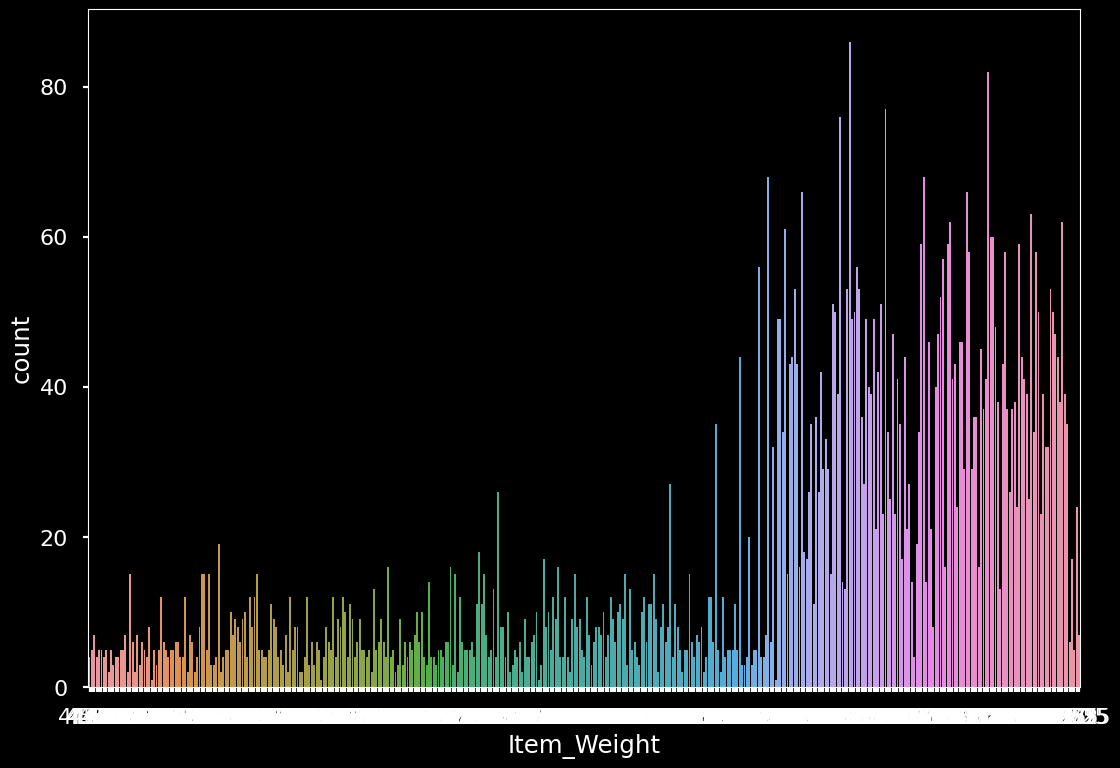

In [14]:
plt.style.use(['dark_background','seaborn-muted', 'seaborn-poster'])
ax = sns.countplot(data = df, x = 'Item_Weight');

In [15]:
#inspect
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [16]:
#Fix Feature name
Outlet_size_content_map = {'High':'Large'}

df['Outlet_Size'] = df['Outlet_Size'].replace(Outlet_size_content_map)

In [17]:
#inspect
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
Large      932
Name: Outlet_Size, dtype: int64

In [18]:
#inspect
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [19]:
#Fix Feature name
Item_fat_content_map = {'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'}

df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(Item_fat_content_map)

In [20]:
#inspect
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

<ipython-input-21-1dc7488d2f1e>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['dark_background','seaborn-muted', 'seaborn-poster'])
<ipython-input-21-1dc7488d2f1e>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['dark_background','seaborn-muted', 'seaborn-poster'])


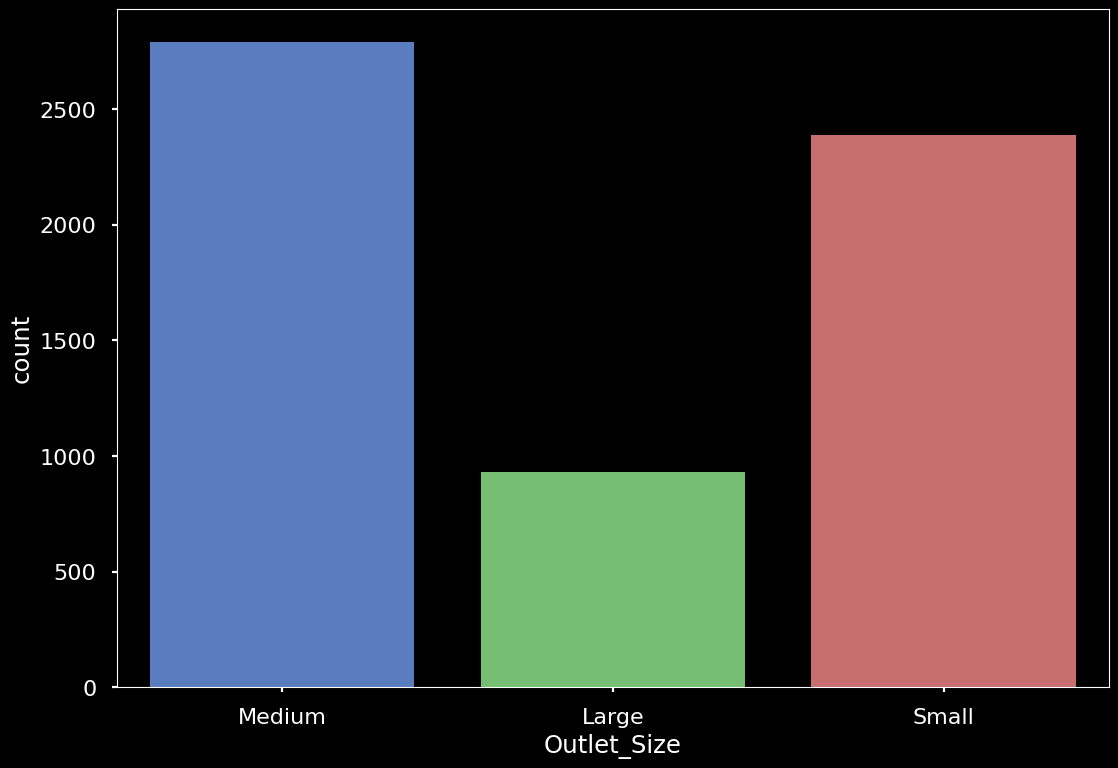

In [21]:
plt.style.use(['dark_background','seaborn-muted', 'seaborn-poster'])
ax = sns.countplot(data = df, x = 'Outlet_Size');

In [22]:
#Checking NUmbers
#Check for unusual or impossible values. (Example a weight, or year that is negative in value.)
df.describe(include="number").round(2)


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.00,8523.00,8523.00,8523.00,8523.00
mean,12.86,0.07,140.99,1997.83,2181.29
std,4.64,0.05,62.28,8.37,1706.50
min,4.56,0.00,31.29,1985.00,33.29
25%,8.77,0.03,93.83,1987.00,834.25
50%,12.60,0.05,143.01,1999.00,1794.33
75%,16.85,0.09,185.64,2004.00,3101.30
max,21.35,0.33,266.89,2009.00,13086.96


In [23]:
## Display the descriptive statistics for the non-numeric columns
df.describe(include="object")

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,2,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5517,1232,935,2793,3350,5577


# Define target and features and train-test-split

In [24]:
#Define X and Y
# The target we are trying to predict
y = df['Item_Outlet_Sales']
# The features we will use to make the prediction
X = df.drop(['Item_Outlet_Sales'], axis=1)

In [25]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,NCG06,16.350,Low Fat,0.029565,Household,256.4646,OUT018,2009,Medium,Tier 3,Supermarket Type2
7510,FDV57,15.250,Regular,0.000000,Snack Foods,179.7660,OUT018,2009,Medium,Tier 3,Supermarket Type2
5828,FDM27,12.350,Regular,0.158716,Meat,157.2946,OUT049,1999,Medium,Tier 1,Supermarket Type1
5327,FDG24,7.975,Low Fat,0.014628,Baking Goods,82.3250,OUT035,2004,Small,Tier 2,Supermarket Type1
4810,FDD05,19.350,Low Fat,0.016645,Frozen Foods,120.9098,OUT045,2002,NaN,Tier 2,Supermarket Type1


## Create column transformer

##Select the numeric columns

In [26]:
#Numeric column names list
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)

Numeric Columns: Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')


##Scale and Create the numeric pipeline

In [27]:
#Use median strategy for numeric
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
num_pipe


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

##Create the tuple for numeric

In [28]:
#Create the tuple for numeric
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
        'Outlet_Establishment_Year'],
       dtype='object'))

##Create Ordinal Pipeline
- Item_Fat_Content
- Outlet_Size
- Outlet_Location_Type
- Outlet_Type

In [29]:
#Ordinal preprocessing and Pipeline

ord_cols = ["Item_Fat_Content","Outlet_Size","Outlet_Location_Type","Outlet_Type"]
#Impute
impute_null_ord = SimpleImputer(strategy='most_frequent')
fatcontent_col_list = ["Low Fat", "Regular"]
outlet_size_list = ["Small", "Medium", "Large"]
outlet_loc_type_list =["Tier 1", "Tier 2", "Tier 3"]
outlet_type_list =["Supermarket Type1", "Supermarket Type2", "Supermarket Type3", "Grocery Store"]

#Transform
ord_encoder = OrdinalEncoder(categories=[fatcontent_col_list, outlet_size_list, outlet_loc_type_list, outlet_type_list])
scaler_ord = StandardScaler()
#instantiate the pipeline
ord_pipeline = make_pipeline(impute_null_ord, ord_encoder, scaler_ord)
ord_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Low Fat', 'Regular'],
                                            ['Small', 'Medium', 'Large'],
                                            ['Tier 1', 'Tier 2', 'Tier 3'],
                                            ['Supermarket Type1',
                                             'Supermarket Type2',
                                             'Supermarket Type3',
                                             'Grocery Store']])),
                ('standardscaler', StandardScaler())])

##Create the tuple for Ordinal

In [30]:
#Create the tuple for Ordinal
ord_tuple = ('ordinal', ord_pipeline, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Low Fat', 'Regular'],
                                             ['Small', 'Medium', 'Large'],
                                             ['Tier 1', 'Tier 2', 'Tier 3'],
                                             ['Supermarket Type1',
                                              'Supermarket Type2',
                                              'Supermarket Type3',
                                              'Grocery Store']])),
                 ('standardscaler', StandardScaler())]),
 ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'])

##Select the categorical columns and create the pipeline

In [31]:
#Categorical column names list
cat_cols = X_train.select_dtypes("object").columns
print("Cat Columns:", cat_cols)
impute_na = SimpleImputer(strategy='constant', fill_value = "Unknown")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_pipe

Cat Columns: Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='Unknown', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

##Create the tuple for categorical

In [32]:
#Create the tuple for categorical
ohe_tuple = ('categorical', ohe_pipe, cat_cols)
ohe_tuple

('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='Unknown', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
        'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
       dtype='object'))

In [33]:
#Column transformer/preprocessor

col_transformer = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple], remainder="drop", verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  Ord...
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

#Fit column transformer onto the data

In [34]:
#fit to training data only or you would create data leakage
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  Ord...
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [35]:
# Transform the training data
X_train_processed = col_transformer.transform(X_train)
# Transform the testing data
X_test_processed = col_transformer.transform(X_test)
# View the processed training data
X_train_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,Item_Identifier_DRB25,Item_Identifier_DRB48,Item_Identifier_DRC01,Item_Identifier_DRC12,Item_Identifier_DRC13,Item_Identifier_DRC25,Item_Identifier_DRC27,Item_Identifier_DRC36,Item_Identifier_DRC49,Item_Identifier_DRD01,Item_Identifier_DRD12,Item_Identifier_DRD13,Item_Identifier_DRD15,Item_Identifier_DRD24,Item_Identifier_DRD25,Item_Identifier_DRD27,Item_Identifier_DRD37,Item_Identifier_DRD49,Item_Identifier_DRD60,Item_Identifier_DRE01,Item_Identifier_DRE03,Item_Identifier_DRE12,Item_Identifier_DRE13,Item_Identifier_DRE15,Item_Identifier_DRE25,Item_Identifier_DRE27,Item_Identifier_DRE37,Item_Identifier_DRE48,Item_Identifier_DRE49,Item_Identifier_DRE60,Item_Identifier_DRF01,Item_Identifier_DRF03,Item_Identifier_DRF13,Item_Identifier_DRF15,Item_Identifier_DRF23,Item_Identifier_DRF25,...,Item_Identifier_NCY54,Item_Identifier_NCZ05,Item_Identifier_NCZ06,Item_Identifier_NCZ17,Item_Identifier_NCZ18,Item_Identifier_NCZ29,Item_Identifier_NCZ30,Item_Identifier_NCZ41,Item_Identifier_NCZ42,Item_Identifier_NCZ53,Item_Identifier_NCZ54,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Large,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Size_Unknown,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,0.827485,-0.712775,1.828109,1.327849,-0.740321,0.287374,1.084948,0.265542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7510,0.566644,-1.291052,0.603369,1.327849,1.350766,0.287374,1.084948,0.265542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5828,-0.121028,1.813319,0.244541,0.136187,1.350766,0.287374,-1.384777,-0.654429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5327,-1.158464,-1.004931,-0.952591,0.732018,-0.740321,-1.384048,-0.149914,-0.654429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0

In [36]:
# Check # of null values in X_train
X_train_processed.isna().sum()

Item_Weight                      0
Item_Visibility                  0
Item_MRP                         0
Outlet_Establishment_Year        0
Item_Fat_Content                 0
                                ..
Outlet_Location_Type_Tier 3      0
Outlet_Type_Grocery Store        0
Outlet_Type_Supermarket Type1    0
Outlet_Type_Supermarket Type2    0
Outlet_Type_Supermarket Type3    0
Length: 1597, dtype: int64

In [37]:
# Check X_train dtypes
X_train_processed.dtypes

Item_Weight                      float64
Item_Visibility                  float64
Item_MRP                         float64
Outlet_Establishment_Year        float64
Item_Fat_Content                 float64
                                  ...   
Outlet_Location_Type_Tier 3      float64
Outlet_Type_Grocery Store        float64
Outlet_Type_Supermarket Type1    float64
Outlet_Type_Supermarket Type2    float64
Outlet_Type_Supermarket Type3    float64
Length: 1597, dtype: object

#Check if it has been scaled

In [38]:
#Confirming Numeric
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 4776 to 7270
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            6392 non-null   object 
 1   Item_Weight                5285 non-null   float64
 2   Item_Fat_Content           6392 non-null   object 
 3   Item_Visibility            6392 non-null   float64
 4   Item_Type                  6392 non-null   object 
 5   Item_MRP                   6392 non-null   float64
 6   Outlet_Identifier          6392 non-null   object 
 7   Outlet_Establishment_Year  6392 non-null   int64  
 8   Outlet_Size                4580 non-null   object 
 9   Outlet_Location_Type       6392 non-null   object 
 10  Outlet_Type                6392 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 599.2+ KB


In [39]:
#Confirming Numeric
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2131 entries, 7503 to 1784
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            2131 non-null   object 
 1   Item_Weight                1775 non-null   float64
 2   Item_Fat_Content           2131 non-null   object 
 3   Item_Visibility            2131 non-null   float64
 4   Item_Type                  2131 non-null   object 
 5   Item_MRP                   2131 non-null   float64
 6   Outlet_Identifier          2131 non-null   object 
 7   Outlet_Establishment_Year  2131 non-null   int64  
 8   Outlet_Size                1533 non-null   object 
 9   Outlet_Location_Type       2131 non-null   object 
 10  Outlet_Type                2131 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 199.8+ KB


###Build the linear model

In [40]:
#Import the libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [41]:
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  Ord...
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [42]:
## Make and fit model
linreg_pipe = make_pipeline(col_transformer, LinearRegression())
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='m...
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [43]:
# Get predictions to use to evaluate model
y_hat_train = linreg_pipe.predict(X_train)
y_hat_test = linreg_pipe.predict(X_test)

In [44]:
## Evaluate model's performance
evaluate_model(y_train, y_hat_train,split='training')
evaluate_model(y_test, y_hat_test,split='testing')

Results for training data:
  - R^2 = 0.671
  - MAE = 738.616
  - MSE = 974839.972
  - RMSE = 987.34

Results for testing data:
  - R^2 = -2.585242235019539e+20
  - MAE = 2234031873308.222
  - MSE = 7.132624609897421e+26
  - RMSE = 26706974014098.68



## Linear Regression Model Interpretation


- This model is underfit due to a lower R^2 value on training data.


##Build the Random Forest model

In [45]:
rf_tree_pipe = make_pipeline(col_transformer, RandomForestRegressor(random_state = 42))
rf_tree_pipe.fit(X_train, y_train)

## Get predictions for training and test data
y_hat_train = rf_tree_pipe.predict(X_train)
y_hat_test = rf_tree_pipe.predict(X_test)

In [46]:
## Evaluate model's performance
evaluate_model(y_train, y_hat_train,split='training')
evaluate_model(y_test, y_hat_test,split='testing')

Results for training data:
  - R^2 = 0.938
  - MAE = 296.977
  - MSE = 183498.019
  - RMSE = 428.367

Results for testing data:
  - R^2 = 0.551
  - MAE = 772.307
  - MSE = 1239418.248
  - RMSE = 1113.292



## Random Forest Model Interpretation


- This model is overfit due to a high training data R^2 value.

The Random Forest Model has the best Test score of 0.551 vs the linear regression model of -2.5

###Tune using GridSearchCV



In [47]:
rf_tree_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
          'Outlet_Establishment_Year'],
         dtype='object')),
                                   ('ordinal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ordinalencoder',
                                                     Ord...
                                   ('categorical',
                                    Pipeline(steps

In [48]:
# Define parameters to tune
params = {'randomforestregressor__max_depth': [None,10,15,20],
          'randomforestregressor__oob_score':[True,False],
          }

In [50]:
# Instantiate the gridsearch
gridsearch = GridSearchCV(rf_tree_pipe, params, n_jobs=-1, cv=None, verbose=1)
# Fit the gridsearch on training data
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          Si...
                                                                         Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [None, 10, 15, 20],
                         'randomforestregressor__oob_score': [True, False]},
             verbose=1)

In [51]:
# Obtain best parameters
gridsearch.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__oob_score': True}

In [52]:
# Define and refit best model
best_rf = gridsearch.best_estimator_
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 688.978
- MSE = 927,919.895
- RMSE = 963.286
- R^2 = 0.686

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 733.314
- MSE = 1,113,331.924
- RMSE = 1,055.145
- R^2 = 0.596


------------------------------------------------------------
## Default Random Forest Model Interpretation
------------------------------------------------------------
Results for training data:
  - R^2 = 0.938
  - MAE = 296.977
  - MSE = 183498.019
  - RMSE = 428.367

Results for testing data:
  - R^2 = 0.551
  - MAE = 772.307
  - MSE = 1239418.248
  - RMSE = 1113.292

##VS
------------------------------------------------------------
##Best Model for Random Forest Model
------------------------------------------------------------
Regression Metrics: Training Data
- MAE = 688.978
- MSE = 927,919.895
- RMSE = 963.286
- R^2 = 0.686

Regression Metrics: Test Data
- MAE = 733.314
- MSE = 1,113,331.924
- RMSE = 1,055.145
- R^2 = 0.596


** Interpretation **
- The fit on the best model is acceptable with the variance between the training and
test data being very low.
- RMSE on the test data is 1055, which means that there is not a big different between the training and test data, resulting in a more accurate prediction


## Best Model selection / Evaluation
- The Random forest model is a better model
- The R^2 value has less variance and is about 60%, which means less variability and a more accurate prediction of sales
- MAE test data comparison is close to the training data, this means low variation and the sales prediction across the stores would be more accurate.
- The model is underfit at 60%, which means variation between the training data and test datas is low, therefore more accurate.

#Overall recommendation
Overall, the best model is definitely the tuned Random Forest Regressor Model. There was still some bias in the model, but by far it outperformed the linear regression model.
